# Trees

## Imports

In [1]:
import pandas as pd
from sqlalchemy import create_engine

server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()


## EXAMPLE: TRAIN FROM 2021-12, PREDICT FOR 2022-01

In [2]:
df = pd.read_sql(
    """
    select ticker, date, agr, bm, idiovol, mom12m, roeq, ret
    from data
    where date in ('2021-12', '2022-01')
    """, 
    conn
)
features = ["agr", "bm", "idiovol", "mom12m", "roeq"]

## TRANSFORM EACH CROSS-SECTION

In [3]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution="normal")

def qtxs(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features + ["ret"]] = df.groupby(
  "date", 
  group_keys=False
)[features + ["ret"]].apply(qtxs)

## FIT A REGRESSION TREE

In [4]:
from sklearn.tree import DecisionTreeRegressor

df = df.dropna()

Xtrain = df[df.date=='2021-12'][features]
ytrain = df[df.date=='2021-12']["ret"]

model = DecisionTreeRegressor(
  max_depth=3,
  random_state=0
)
model.fit(Xtrain, ytrain)

DecisionTreeRegressor(max_depth=3, random_state=0)

## VIEW THE REGRESSION TREE

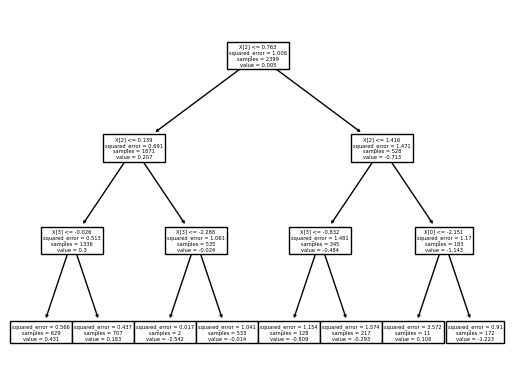

In [5]:
from sklearn.tree import plot_tree
_ = plot_tree(model)

## FEATURE IMPORTANCE

In [6]:
pd.Series(model.feature_importances_, index=Xtrain.columns)

agr        0.035699
bm         0.000000
idiovol    0.857679
mom12m     0.106622
roeq       0.000000
dtype: float64

## SCORES ON TRAINING AND TEST DATA

### R-squared on training data

In [7]:
model.score(Xtrain, ytrain)

0.2122033914935202

### R-squared on test data

In [8]:
Xtest = df[df.date=='2022-01'][features]
ytest = df[df.date=='2022-01']["ret"]
model.score(Xtest, ytest)

0.029764428759346373

In [10]:
train_score = []
test_score = []
for i in range(1, 11):
    model = DecisionTreeRegressor(
    max_depth=i,
    random_state=0
    )
    model.fit(Xtrain, ytrain)
    train_score.append(model.score(Xtrain, ytrain))
    test_score.append(model.score(Xtest, ytest))

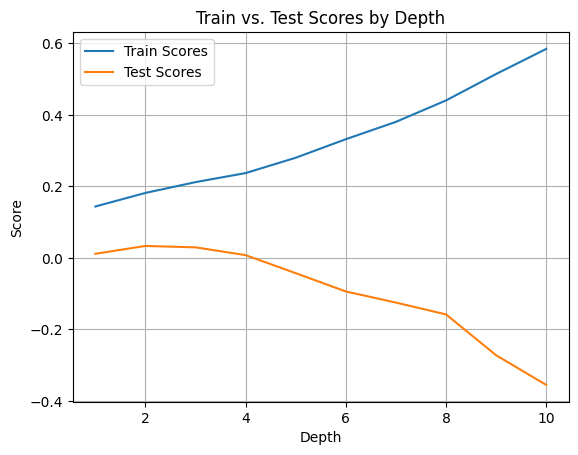

In [13]:
import matplotlib.pyplot as plt



depths = range(1,11)

plt.plot(depths, train_score, label='Train Scores')
plt.plot(depths, test_score, label='Test Scores')

# Add labels and legend
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Train vs. Test Scores by Depth')
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()